# InferSent Primer

## Installation

In [10]:
# !mkdir GloVe
# !curl -Lo GloVe/glove.840B.300d.zip http://nlp.stanford.edu/data/glove.840B.300d.zip
# !unzip GloVe/glove.840B.300d.zip -d GloVe/
!mkdir fastText
!curl -Lo fastText/crawl-300d-2M.vec.zip https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip
!unzip fastText/crawl-300d-2M.vec.zip -d fastText/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1453M  100 1453M    0     0  32.8M      0  0:00:44  0:00:44 --:--:-- 33.2M
Archive:  fastText/crawl-300d-2M.vec.zip
  inflating: fastText/crawl-300d-2M.vec  


In [ ]:
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/facebookresearch/InferSent.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # clone and install dependencies
  !git clone -q {git_repo_url}
  !pip install -q youtube-dl cython gdown
  !pip install -q -U PyYAML
  !apt-get install -y -q libyaml-dev
  !cd {project_name} && python setup.py build develop --user
  
import sys
sys.path.append(project_name)
import time
import matplotlib
import matplotlib.pylab as plt
plt.rcParams["axes.grid"] = False

from IPython.display import YouTubeVideo

In [3]:
!mkdir encoder
!curl -Lo encoder/infersent1.pkl https://dl.fbaipublicfiles.com/infersent/infersent1.pkl
!curl -Lo encoder/infersent2.pkl https://dl.fbaipublicfiles.com/infersent/infersent2.pkl

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  146M  100  146M    0     0  26.3M      0  0:00:05  0:00:05 --:--:-- 32.3M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  146M  100  146M    0     0  28.2M      0  0:00:05  0:00:05 --:--:-- 31.1M


In [7]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
from random import randint

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Download our InferSent models (V1 trained with GloVe, V2 trained with fastText).

Note that infersent1 is trained with GloVe (which have been trained on text preprocessed with the PTB tokenizer) and infersent2 is trained with fastText (which have been trained on text preprocessed with the MOSES tokenizer). The latter also removes the padding of zeros with max-pooling which was inconvenient when embedding sentences outside of their batches.

## Load Model

In [11]:
# Load model
from models import InferSent
model_version = 2
MODEL_PATH = "encoder/infersent%s.pkl" % model_version
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': model_version}
model = InferSent(params_model)
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [ ]:
# Keep it on CPU or put it on GPU
use_cuda = False
model = model.cuda() if use_cuda else model

In [ ]:
# Set word vector path for the model
# If infersent1 -> use GloVe embeddings. If infersent2 -> use InferSent embeddings.
W2V_PATH = 'GloVe/glove.840B.300d.txt' if model_version == 1 else 'fastText/crawl-300d-2M.vec'
model.set_w2v_path(W2V_PATH)

In [14]:
# Load embeddings of K most frequent words
model.build_vocab_k_words(K=100000)

Vocab size : 100000


## Load Sentences

In [16]:
!wget https://raw.githubusercontent.com/facebookresearch/InferSent/master/samples.txt

--2020-04-12 12:38:25--  https://raw.githubusercontent.com/facebookresearch/InferSent/master/samples.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 580976 (567K) [text/plain]
Saving to: ‘samples.txt’

samples.txt         100%[===================>] 567.36K  --.-KB/s    in 0.06s   

2020-04-12 12:38:25 (9.63 MB/s) - ‘samples.txt’ saved [580976/580976]



In [17]:
# Load some sentences
sentences = []
with open('samples.txt') as f:
    for line in f:
        sentences.append(line.strip())
print(len(sentences))

9815


In [18]:
sentences[:5]

['Everyone really likes the newest benefits',
 'The Government Executive articles housed on the website are not able to be searched .',
 'I like him for the most part , but would still enjoy seeing someone beat him .',
 'My favorite restaurants are always at least a hundred miles away from my house .',
 'I know exactly .']

## Encode sentences

In [19]:
embeddings = model.encode(sentences, bsize=128, tokenize=False, verbose=True)
print('nb sentences encoded : {0}'.format(len(embeddings)))

Nb words kept : 127563/130068 (98.1%)
Speed : 46.2 sentences/s (cpu mode, bsize=128)
nb sentences encoded : 9815


## Visualization

In [20]:
np.linalg.norm(model.encode(['the cat eats.']))

2.458544

In [21]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

cosine(model.encode(['the cat eats.'])[0], model.encode(['the cat drinks.'])[0])

0.7549329

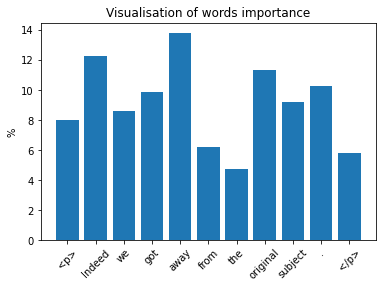

In [22]:
idx = randint(0, len(sentences))
_, _ = model.visualize(sentences[idx])

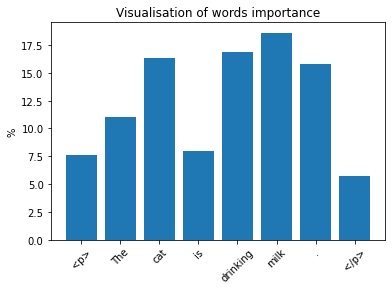

In [23]:
my_sent = 'The cat is drinking milk.'
_, _ = model.visualize(my_sent)

## Squad Insersent Q&A

https://github.com/aswalin/SQuAD